In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Food101 paper
- Link of the paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

**This notebook is inspired from ZTM's Tensorflow course**<br>
Link: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb


## Importing helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-10 16:42:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-10 16:42:13 (60.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Downloading and preprocessing data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2023-06-10 16:56:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.24.48, 2404:6800:4006:804::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.24.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.0MB/s    in 67s     

2023-06-10 16:57:52 (23.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [8]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [14]:
len(train_dir), len(test_dir)

(34, 33)

In [10]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caesar_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '

In [11]:
import tensorflow as tf
from tensorflow.keras import preprocessing

In [12]:
train_data_gen = preprocessing.image_dataset_from_directory(train_dir,
                                                            label_mode="categorical",
                                                            image_size=(224, 224),
                                                            batch_size=32)

test_data_gen = preprocessing.image_dataset_from_directory(test_dir,
                                                           label_mode="categorical",
                                                           image_size=(224, 224),
                                                           batch_size=32,
                                                           shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Creating `ModelCheckpoint`

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
checkpoint_path = "10_percent_data_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Creating the augmentation layer

In [17]:
from tensorflow.keras import layers, Sequential

In [20]:
data_augmentation = Sequential([
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal")
], name="data_augmentation")

## Importing `EfficientNetB0` as `base_model`

In [22]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 2s 0us/step


## Creating model

In [27]:
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_gen.class_names), activation="softmax", name="output_layer")(x)

In [28]:
# don't know how many model we are going to create so, named model_0
model_0 = tf.keras.Model(inputs, outputs)

In [29]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [30]:
history_0 = model_0.fit(train_data_gen,
            epochs=5,
            steps_per_epoch=len(train_data_gen),
            validation_data=test_data_gen,
            validation_steps=int(0.15 * len(test_data_gen)),
            callbacks=[create_tensorboard_callback("transfer_learning", "model_0"),
                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/model_0/20230610-175639
Epoch 1/5
237/237 [==============================] - 75s 282ms/step - loss: 3.3644 - accuracy: 0.2741 - val_loss: 2.6087 - val_accuracy: 0.4118
Epoch 2/5
237/237 [==============================] - 48s 199ms/step - loss: 2.2059 - accuracy: 0.4914 - val_loss: 2.1211 - val_accuracy: 0.4902
Epoch 3/5
237/237 [==============================] - 46s 191ms/step - loss: 1.8182 - accuracy: 0.5654 - val_loss: 1.9418 - val_accuracy: 0.5056
Epoch 4/5
237/237 [==============================] - 38s 160ms/step - loss: 1.6093 - accuracy: 0.6082 - val_loss: 1.8914 - val_accuracy: 0.5106
Epoch 5/5
237/237 [==============================] - 38s 157ms/step - loss: 1.4505 - accuracy: 0.6450 - val_loss: 1.8243 - val_accuracy: 0.5217


In [31]:
model_0.evaluate(test_data_gen)

790/790 [==============================] - 52s 65ms/step - loss: 1.5755 - accuracy: 0.5864


[1.575507402420044, 0.5864158272743225]

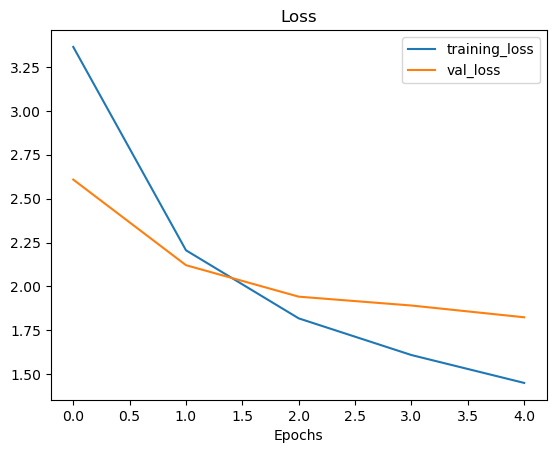

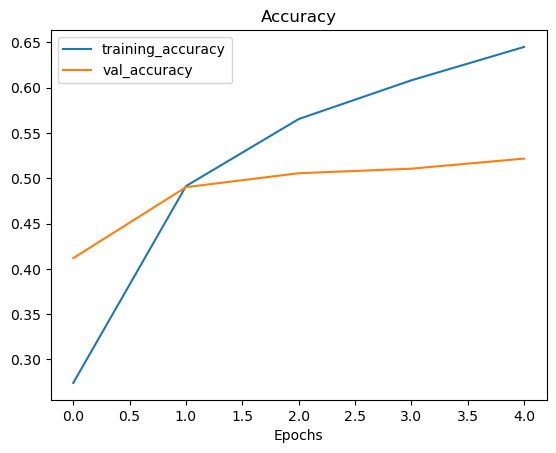

In [32]:
plot_loss_curves(history_0)